In [14]:
setwd("C:/Users/Sandeep Kushwaha/Desktop/abundance_plot")


In [15]:
df1 <- read.csv("PRJEN43443_edited.csv")
df2 <- read.csv("PRJNA544129_edited.csv")
df3 <- read.csv("PRJNA551141_edited.csv")
df4 <- read.csv("PRJNA556769_edited.csv")
df5 <- read.csv("PRJNA591729_edited.csv")
df6 <- read.csv("PRJNA627642_edited.csv")
df7 <- read.csv("PRJNA778892_edited.csv")


In [ ]:
# Load required libraries
library(ggplot2)
library(viridis)
library(dplyr)
library(tidyr)
library(vegan)  # For diversity calculations

# Define publication theme
pub_theme <- theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 10),
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill = "white", colour = "white"),
    plot.background = element_rect(fill = "white", colour = "white")
  )

# Read all CSV files
df1 <- read.csv("PRJEN43443_edited.csv")
df2 <- read.csv("PRJNA544129_edited.csv")
df3 <- read.csv("PRJNA551141_edited.csv")
df4 <- read.csv("PRJNA556769_edited.csv")
df5 <- read.csv("PRJNA591729_edited.csv")
df6 <- read.csv("PRJNA627642_edited.csv")
df7 <- read.csv("PRJNA778892_edited.csv")

# Store dataframes in a list for easier processing
data_list <- list(df1, df2, df3, df4, df5, df6, df7)
project_names <- c("PRJEN43443", "PRJNA544129", "PRJNA551141", 
                   "PRJNA556769", "PRJNA591729", "PRJNA627642", "PRJNA778892")
######################
# Function to calculate alpha diversity indices
calculate_alpha_diversity <- function(df, project_name) {
  # Assuming your data has species/OTU abundance columns
  # Remove non-numeric columns (like sample names, metadata)
  numeric_cols <- sapply(df, is.numeric)
  abundance_data <- df[, numeric_cols]
  
  # Remove columns with all zeros
  abundance_data <- abundance_data[, colSums(abundance_data) > 0]
  
  # Calculate alpha diversity indices
  shannon <- diversity(abundance_data, index = "shannon")
  simpson <- diversity(abundance_data, index = "simpson")
  invsimpson <- diversity(abundance_data, index = "invsimpson")
  
  # Calculate richness (number of non-zero species)
  richness <- rowSums(abundance_data > 0)
  
  # Calculate Chao1 (requires species counts as integers)
  chao1 <- sapply(1:nrow(abundance_data), function(i) {
    sample_data <- as.numeric(abundance_data[i, ])
    sample_data <- sample_data[sample_data > 0]  # Remove zeros
    if(length(sample_data) > 0) {
      estimateR(round(sample_data))[2]  # Chao1 estimate
    } else {
      NA
    }
  })
  
  # Create dataframe with results
  alpha_results <- data.frame(
    Project = project_name,
    Sample = 1:nrow(abundance_data),
    Shannon = shannon,
    Simpson = simpson,
    InvSimpson = invsimpson,
    Richness = richness,
    Chao1 = chao1
  )
  
  return(alpha_results)
}

############################
# Function to calculate beta diversity indices
calculate_beta_diversity <- function(df, project_name) {
  # Get numeric abundance data
  numeric_cols <- sapply(df, is.numeric)
  abundance_data <- df[, numeric_cols]
  abundance_data <- abundance_data[, colSums(abundance_data) > 0]
  
  # Calculate distance matrices
  bray_dist <- vegdist(abundance_data, method = "bray")
  jaccard_dist <- vegdist(abundance_data, method = "jaccard", binary = TRUE)
  
  # Convert distance matrices to vectors
  bray_values <- as.vector(bray_dist)
  jaccard_values <- as.vector(jaccard_dist)
  
  # Create dataframe with results
  beta_results <- data.frame(
    Project = project_name,
    Comparison = rep(c("Bray-Curtis", "Jaccard"), 
                    c(length(bray_values), length(jaccard_values))),
    Dissimilarity = c(bray_values, jaccard_values)
  )
  
  return(beta_results)
}
################################
# Calculate diversity indices for all projects
all_alpha_data <- data.frame()
all_beta_data <- data.frame()

cat("Calculating diversity indices...\n")

for(i in 1:length(data_list)) {
  cat("Processing", project_names[i], "...\n")
  
  # Calculate alpha diversity
  alpha_results <- calculate_alpha_diversity(data_list[[i]], project_names[i])
  all_alpha_data <- rbind(all_alpha_data, alpha_results)
  
  # Calculate beta diversity
  beta_results <- calculate_beta_diversity(data_list[[i]], project_names[i])
  all_beta_data <- rbind(all_beta_data, beta_results)
}

# Convert alpha diversity data to long format
alpha_long <- all_alpha_data %>%
  select(-Sample) %>%
  pivot_longer(cols = c(Shannon, Simpson, InvSimpson, Richness, Chao1), 
               names_to = "Index", values_to = "Value")

# Remove any NA values
alpha_long <- alpha_long[!is.na(alpha_long$Value), ]
beta_diversity <- all_beta_data[!is.na(all_beta_data$Dissimilarity), ]

cat("Generating plots...\n")

# Generate Alpha Diversity Plots (combined across all projects)
for (index_name in unique(alpha_long$Index)) {
  
  # Subset the data for the current index
  subset_data <- subset(alpha_long, Index == index_name)
  
  # Generate the plot for this index with projects on x-axis
  p <- ggplot(subset_data, aes(x = Project, y = Value, fill = Project)) +
    geom_boxplot(alpha = 0.7, outlier.shape = 16, outlier.size = 2) +
    geom_jitter(width = 0.2, size = 2, alpha = 0.7) +
    scale_fill_viridis_d(option = "viridis", begin = 0.2, end = 0.8) +
    labs(
      title = paste("Alpha Diversity -", index_name, "(All Projects)"),
      x = "Project",
      y = "Index Value"
    ) +
    pub_theme +
    theme(
      legend.position = "none",
      axis.text.x = element_text(angle = 45, hjust = 1)
    ) +
    stat_summary(fun = mean, geom = "point", shape = 23, size = 3, 
                 fill = "white", color = "black")
  
  # Save the plot
  filename <- paste0("alpha_diversity_", index_name, "_all_projects.png")
  ggsave(filename = filename, plot = p, width = 10, height = 6, dpi = 300)
  cat("Saved:", filename, "\n")
}

# Generate Beta Diversity Plots (combined across all projects)
fill_colors <- c("Bray-Curtis" = "#E31A1C", "Jaccard" = "#1F78B4")

for (comp in unique(beta_diversity$Comparison)) {
  
  # Subset the data for the current comparison
  subset_data <- subset(beta_diversity, Comparison == comp)
  
  # Generate the plot for this comparison with projects on x-axis
  p <- ggplot(subset_data, aes(x = Project, y = Dissimilarity, fill = Project)) +
    geom_boxplot(alpha = 0.7, outlier.shape = 16, outlier.size = 2) +
    geom_jitter(width = 0.2, size = 2, alpha = 0.6) +
    scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
    labs(
      title = paste("Beta Diversity -", comp, "(All Projects)"),
      x = "Project",
      y = "Dissimilarity Value"
    ) +
    pub_theme +
    theme(
      legend.position = "none",
      axis.text.x = element_text(angle = 45, hjust = 1)
    ) +
    stat_summary(fun = mean, geom = "point", shape = 23, size = 3, 
                 fill = "white", color = "black")
  
######################################################################################################
  # Save the plot
  filename <- paste0("beta_diversity_", gsub(" ", "_", comp), "_all_projects.png")
  ggsave(filename = filename, plot = p, width = 10, height = 6, dpi = 300)
  cat("Saved:", filename, "\n")
}
########################################################################### SUMMARY PLOT #########################################################################
# Optional: Create summary plots showing all indices together
# Alpha diversity summary plot
p_alpha_summary <- ggplot(alpha_long, aes(x = Index, y = Value, fill = Index)) +
  geom_boxplot(alpha = 0.7, outlier.shape = 16, outlier.size = 1) +
  facet_wrap(~Project, scales = "free_y", ncol = 3) +
  scale_fill_viridis_d(option = "viridis") +
  labs(
    title = "Alpha Diversity Summary - All Indices and Projects",
    x = "Diversity Index",
    y = "Index Value"
  ) +
  pub_theme +
  theme(
    legend.position = "bottom",
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text = element_text(size = 10, face = "bold")
  )

ggsave("alpha_diversity_summary_all.png", p_alpha_summary, width = 15, height = 10, dpi = 300)
cat("Saved: alpha_diversity_summary_all.png\n")

# Beta diversity summary plot
p_beta_summary <- ggplot(beta_diversity, aes(x = Comparison, y = Dissimilarity, fill = Comparison)) +
  geom_boxplot(alpha = 0.7, outlier.shape = 16, outlier.size = 1) +
  facet_wrap(~Project, scales = "free_y", ncol = 3) +
  scale_fill_manual(values = fill_colors) +
  labs(
    title = "Beta Diversity Summary - All Comparisons and Projects",
    x = "Dissimilarity Index",
    y = "Dissimilarity Value"
  ) +
  pub_theme +
  theme(
    legend.position = "bottom",
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text = element_text(size = 10, face = "bold")
  )
#
ggsave("beta_diversity_summary_all.png", p_beta_summary, width = 15, height = 10, dpi = 300)
cat("Saved: beta_diversity_summary_all.png\n")
#################
cat("\nAll diversity calculations and plots completed!\n")
cat("Generated files:\n")
cat("- Individual alpha diversity plots for each index (all projects combined)\n")
cat("- Individual beta diversity plots for each comparison (all projects combined)\n")
cat("- Summary plots showing all indices and projects together\n")
#########################################################
# Display summary statistics
cat("\nSummary Statistics:\n")
print("Alpha Diversity Summary:")
print(alpha_long %>% group_by(Index) %>% summarise(Mean = mean(Value, na.rm = TRUE), 
                                                   SD = sd(Value, na.rm = TRUE),                    # SD is standard deviation 
                                                   .groups = 'drop'))

print("Beta Diversity Summary:")
print(beta_diversity %>% group_by(Comparison) %>% summarise(Mean = mean(Dissimilarity, na.rm = TRUE),  # here SD is standard deviations
                                                           SD = sd(Dissimilarity, na.rm = TRUE),
                                                           .groups = 'drop'))

Calculating diversity indices...
Processing PRJEN43443 ...
Processing PRJNA544129 ...
Processing PRJNA551141 ...
Processing PRJNA556769 ...
Processing PRJNA591729 ...
Processing PRJNA627642 ...
Processing PRJNA778892 ...


Warning message in sqrt(sum(Deriv.Ch1 %*% t(Deriv.Ch1) * (diag(a) - a %*% t(a)/S.ACE))):
"NaNs produced"


Generating plots...
Saved: alpha_diversity_Shannon_all_projects.png 
Saved: alpha_diversity_Simpson_all_projects.png 
Saved: alpha_diversity_InvSimpson_all_projects.png 
Saved: alpha_diversity_Richness_all_projects.png 
Saved: alpha_diversity_Chao1_all_projects.png 
Saved: beta_diversity_Bray-Curtis_all_projects.png 
Saved: beta_diversity_Jaccard_all_projects.png 
Saved: alpha_diversity_summary_all.png
Saved: beta_diversity_summary_all.png

All diversity calculations and plots completed!
Generated files:
- Individual alpha diversity plots for each index (all projects combined)
- Individual beta diversity plots for each comparison (all projects combined)
- Summary plots showing all indices and projects together

Summary Statistics:
[1] "Alpha Diversity Summary:"
# A tibble: 5 × 3
  Index       Mean     SD
  <chr>      <dbl>  <dbl>
1 Chao1      6.71  13.5  
2 InvSimpson 3.47   7.54 
3 Richness   6.36  13.1  
4 Shannon    0.699  0.928
5 Simpson    0.311  0.335
[1] "Beta Diversity Summary:

In [17]:
# Display summary statistics
cat("\nSummary Statistics:\n")
print("Alpha Diversity Summary:")
print(alpha_long %>% group_by(Index) %>% summarise(Mean = mean(Value, na.rm = TRUE),  ### here SD is standard deviation
                                                   SD = sd(Value, na.rm = TRUE),
                                                   .groups = 'drop'))



Summary Statistics:
[1] "Alpha Diversity Summary:"
# A tibble: 5 × 3
  Index       Mean     SD
  <chr>      <dbl>  <dbl>
1 Chao1      6.71  13.5  
2 InvSimpson 3.47   7.54 
3 Richness   6.36  13.1  
4 Shannon    0.699  0.928
5 Simpson    0.311  0.335


In [18]:

print("Beta Diversity Summary:")
print(beta_diversity %>% group_by(Comparison) %>% summarise(Mean = mean(Dissimilarity, na.rm = TRUE), 
                                                           SD = sd(Dissimilarity, na.rm = TRUE),
                                                           .groups = 'drop'))

[1] "Beta Diversity Summary:"


# A tibble: 2 × 3
  Comparison   Mean    SD
  <chr>       <dbl> <dbl>
1 Bray-Curtis 0.648 0.318
2 Jaccard     0.493 0.361


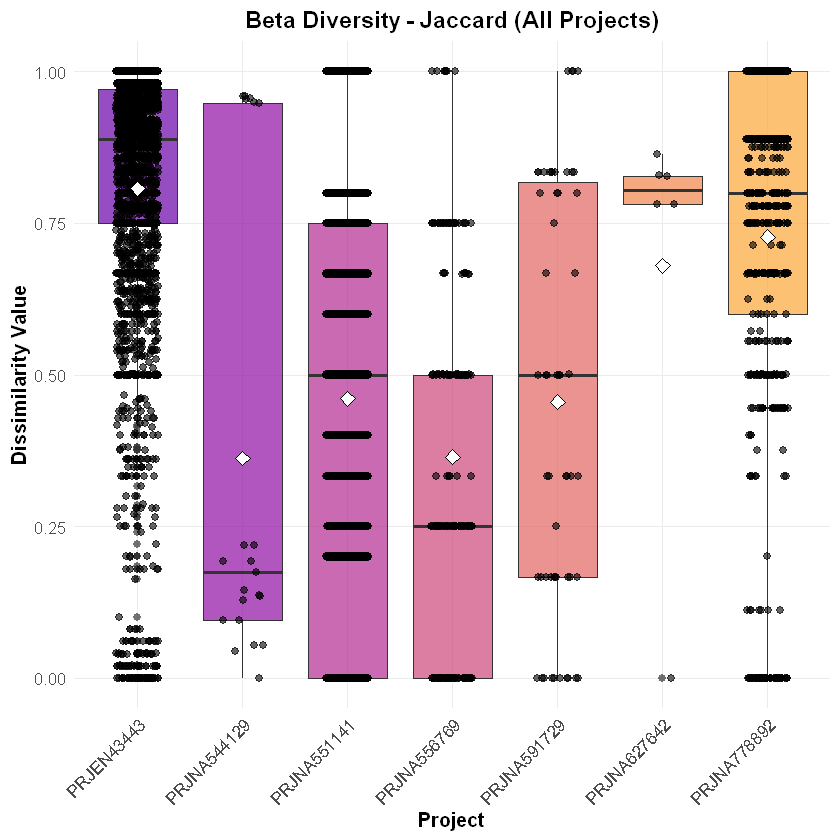

In [6]:
plot(p)